# 해상도 개선하기

## 1-1 고해상도 사진를 이용해 해상도 개선하기

(944, 1140, 3)


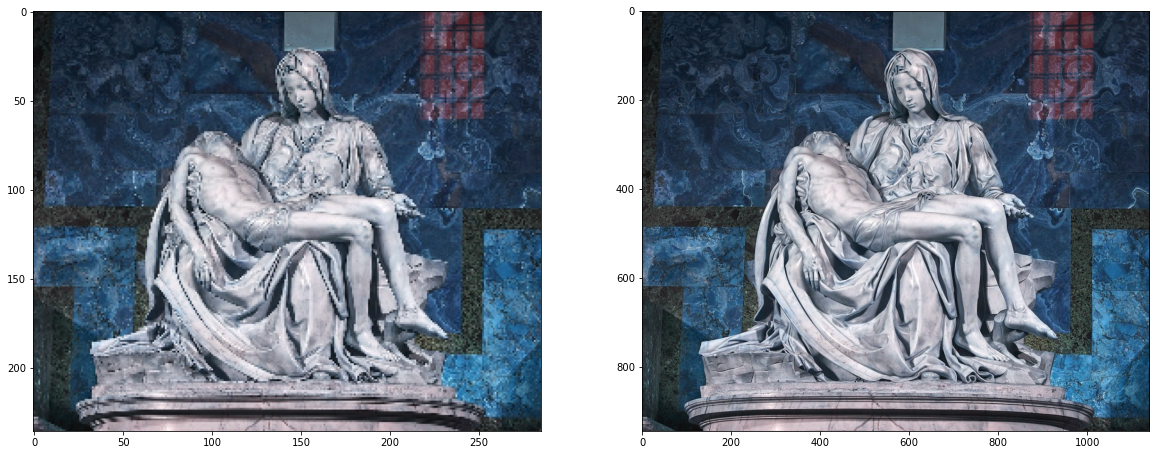

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 데이터를 불러옵니다.
train_path = os.getenv('HOME') + '/aiffel/super_resolution/data/high_test_image.jpg'
train = cv2.imread(train_path)

    
bicubic_train = cv2.resize(
    train,
    dsize=(285, 236),
    interpolation=cv2.INTER_CUBIC 
)


plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_train)
plt.subplot(1,2,2); plt.imshow(train)
print(train.shape)

In [2]:
import tensorflow as tf
model_file = os.getenv('HOME')+'/aiffel/super_resolution/srgan_G.h5'
srgan = tf.keras.models.load_model(model_file)

In [3]:
def apply_srgan(image):
    image = tf.cast(image[np.newaxis, ...], tf.float32)
    sr = srgan.predict(image)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    return np.array(sr)[0]

In [4]:
srgan_train = apply_srgan(bicubic_train)

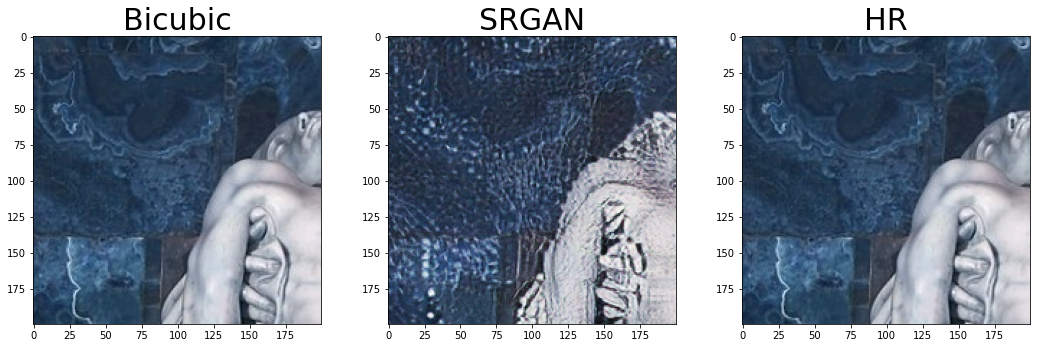

In [5]:
bicubic_train = cv2.resize(
    train,
    dsize=(1140, 944),
    interpolation=cv2.INTER_CUBIC
)
def crop(image, left_top, x=200, y=200):
    return image[left_top[0]:(left_top[0]+x), left_top[1]:(left_top[1]+y), :]

left_tops = [(220, 200)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_train, left_top, 200, 200)
    img2 = crop(srgan_train , left_top, 200, 200)
    img3 = crop(train, left_top, 200, 200)
    images.extend([img1, img2, img3])

labels = ["Bicubic", "SRGAN", "HR"] * 3

plt.figure(figsize=(18,18))
for i in range(3):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

노드와 다르게 SRGAN이 심하게 어그러져있는것을 볼 수 있다. 생성 모델의 한계점이 있는 것을 느꼈다.   
늘렸다가 줄인것에 대한 영향일지 몰라도 Bicubic도 해상도면에서 떨어지지 않는다는 것을 볼 수 있다.

## 1-2. 저해상도 사진을 고해상도로 바꾸기 vs SRGAN을 이용하기

In [6]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt


# 데이터를 불러옵니다.
david_path = os.getenv('HOME') + '/aiffel/super_resolution/data/david.jpg'
david = cv2.imread(david_path)

print(david.shape)

(160, 155, 3)


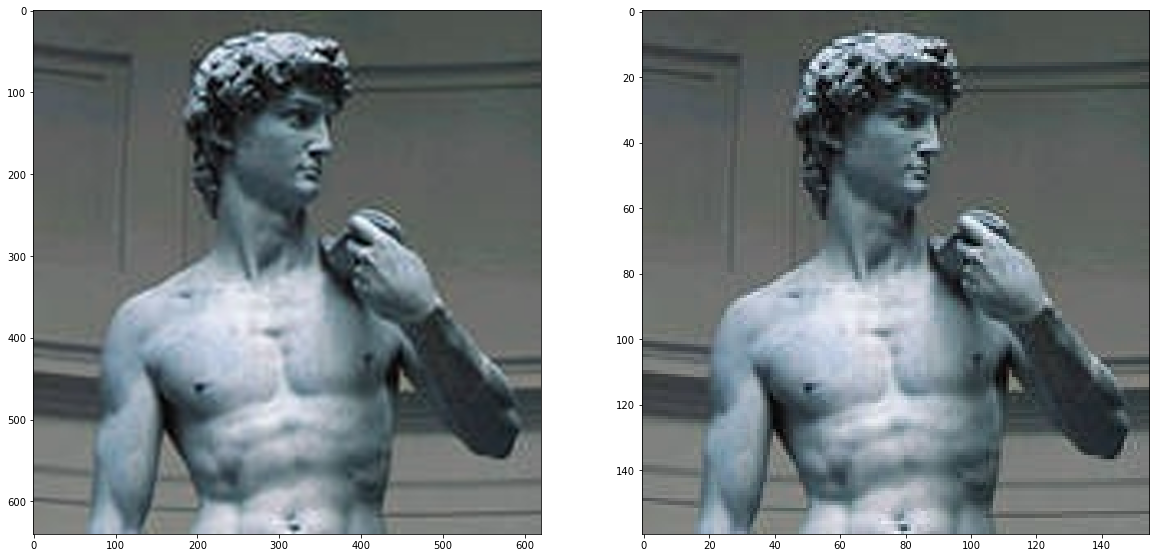

In [7]:
bicubic_david = cv2.resize(
    david,
    dsize=(620, 640), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC # bicubic 설정
)

# 저해상도 및 고해상도 이미지를 시각화 합니다.
plt.figure(figsize=(20,10))
plt.subplot(1,2,1); plt.imshow(bicubic_david)
plt.subplot(1,2,2); plt.imshow(david)

In [8]:
srgan_david = apply_srgan(david)

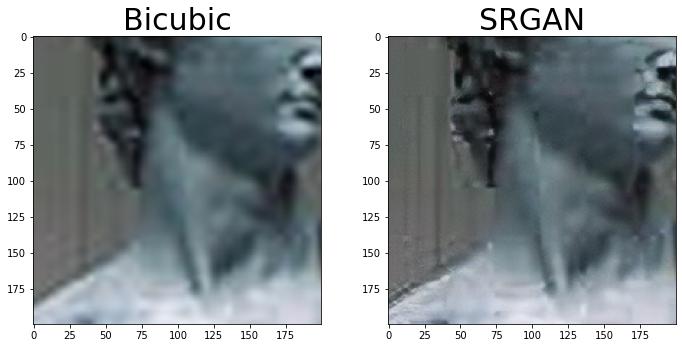

In [9]:
left_tops = [(150, 150)]

images = []
for left_top in left_tops:
    img1 = crop(bicubic_david, left_top, 200, 200)
    img2 = crop(srgan_david , left_top, 200, 200)
    images.extend([img1, img2])

labels = ["Bicubic", "SRGAN"] * 3

plt.figure(figsize=(18,18))
for i in range(2):
    plt.subplot(3,3,i+1) 
    plt.imshow(images[i])
    plt.title(labels[i], fontsize=30)

이번 경우 GAN이 bicubic보다 좀더 선명함을 느낄 수 있다. 다만 생성모델이기 때문에 약간 선에 대한 투박함이 존재한다.    
저해상도같은 경우 낮은 해상도에서 시작해 고해상도로 늘렸기 때문에 앞선 실험보다 개선점이 낮았다라는 추측을 하게 된다.

## 2. gif 생성하기

In [10]:
import cv2

# 다운 받은 파일의 경로를 설정해 주세요.
gif_path = os.getenv('HOME') + '/aiffel/super_resolution/data/wine_lr.gif'
gif = cv2.VideoCapture(gif_path)

isTrue = True
frames = []
while isTrue:
    isTrue, frame = gif.read()
    if isTrue:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        frames.append(frame)
frames = frames[:8]
print("frame 수 :", len(frames))
print("frame 크기 :", (frames[0].shape))


frame 수 : 8
frame 크기 : (340, 355, 3)


### bicubic으로 늘려주기

In [11]:
frames_bicubic = []
for frame in frames:
    frames_sr = cv2.resize(
    frame,
    dsize=(1420, 1360), # 고해상도 이미지 크기로 설정
    interpolation=cv2.INTER_CUBIC) # bicubic 설정
    frames_bicubic.append(frames_sr)

In [12]:
import imageio
new_gif_path = os.getenv('HOME') + '/aiffel/super_resolution/data/wine_bicubic.gif'
imageio.mimsave(new_gif_path, frames_bicubic)

### SRGAN으로 늘려주기

In [13]:
frames_srgan = []
for frame in frames:
    frames_sr = apply_srgan(frame)
    frames_srgan.append(frames_sr)
    

In [14]:
new_gif_path_2 = os.getenv('HOME') + '/aiffel/super_resolution/data/wine_srgan.gif'
imageio.mimsave(new_gif_path_2, frames_srgan)

In [15]:
show_gif(gif_path, width = 300)

NameError: name 'show_gif' is not defined

In [ ]:
from IPython.display import Image as show_gif
show_gif(new_gif_path, width = 300)

In [ ]:
show_gif(new_gif_path_2, width = 300)

화질의 선명성은 SRGAN이 bicubic에 앞선다. 그러나 자세히 보면 컴 아랫쪽에 SRGAN으로 해상도 개선한 gif는 빛이 물처럼 흔들리는 곳이 bicubic보다 퍼지게 나타난다.    
결론적으로 bicubic은 선명성이 SRGAN보다 낮지만 정확도는 높다. SRGAN은 선명성이 높지만 생성모델의 한계때문에 사진의 몇가지 오류점이 존재한다.    